In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('./UCYdemo_2022_2023.csv', index_col=[0], parse_dates=[0])
pjme = pjme.drop(columns=['GHI','Pdc','Tmod'])

/var/folders/gb/sjxj389901n7jtz0mzqvm0xr0000gn/T/ipykernel_24913/1672503854.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pjme = pd.read_csv('./UCYdemo_2022_2023.csv', index_col=[0], parse_dates=[0])


In [3]:
# Will not work with mult variables, instead (b/c I keep hitting play)
print('u dumb')
#color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
#_ = pjme.plot(style='-', figsize=(15,5), color=color_pal[0], title='UCY PV Output')

u dumb


In [4]:
split_date = '01-Jul-2023'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [5]:
print('u dumb')
#_ = pjme_test \
#   .rename(columns={'Pac': "TEST SET"}) \
#   .join(pjme_train.rename(columns={'Pac': 'TRAINING SET'}), how='outer') \
#    .plot(figsize=(15,5), title="PV Output", style='.')

u dumb


In [6]:
pjme_train.head(5)

,Tamb,RH,POA,Pac
Datetime,,,,
2022-01-01 00:00:00,15.18,83.3,0.0,0.002
2022-01-01 00:30:00,15.04,85.1,0.0,0.002
2022-01-01 01:00:00,14.73,86.5,0.0,0.002
2022-01-01 01:30:00,14.32,87.2,0.0,0.002
2022-01-01 02:00:00,13.98,87.7,0.0,0.002


In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    # df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    # df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    # df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','quarter','month',
           'dayofyear','weekofyear', 'Tamb', 'RH', 'POA']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X_train, y_train = create_features(pjme_train, label='Pac')
X_test, y_test = create_features(pjme_test, label='Pac')

In [9]:
reg = xgb.XGBRegressor(n_estimators=500)
reg.set_params(
    eval_metric='rmse',
    early_stopping_rounds=10
    )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        
        verbose=True
    )

[0]	validation_0-rmse:0.20071	validation_1-rmse:0.19168
[1]	validation_0-rmse:0.14093	validation_1-rmse:0.13235
[2]	validation_0-rmse:0.09910	validation_1-rmse:0.09111
[3]	validation_0-rmse:0.06983	validation_1-rmse:0.06257
[4]	validation_0-rmse:0.04945	validation_1-rmse:0.04298
[5]	validation_0-rmse:0.03526	validation_1-rmse:0.02944
[6]	validation_0-rmse:0.02550	validation_1-rmse:0.02047
[7]	validation_0-rmse:0.01889	validation_1-rmse:0.01487
[8]	validation_0-rmse:0.01451	validation_1-rmse:0.01184
[9]	validation_0-rmse:0.01169	validation_1-rmse:0.01053
[10]	validation_0-rmse:0.00994	validation_1-rmse:0.01006


[11]	validation_0-rmse:0.00887	validation_1-rmse:0.01004
[12]	validation_0-rmse:0.00826	validation_1-rmse:0.01009
[13]	validation_0-rmse:0.00787	validation_1-rmse:0.01012
[14]	validation_0-rmse:0.00750	validation_1-rmse:0.01022
[15]	validation_0-rmse:0.00731	validation_1-rmse:0.01031
[16]	validation_0-rmse:0.00713	validation_1-rmse:0.01030
[17]	validation_0-rmse:0.00704	validation_1-rmse:0.01037
[18]	validation_0-rmse:0.00693	validation_1-rmse:0.01028
[19]	validation_0-rmse:0.00687	validation_1-rmse:0.01026
[20]	validation_0-rmse:0.00682	validation_1-rmse:0.01027


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

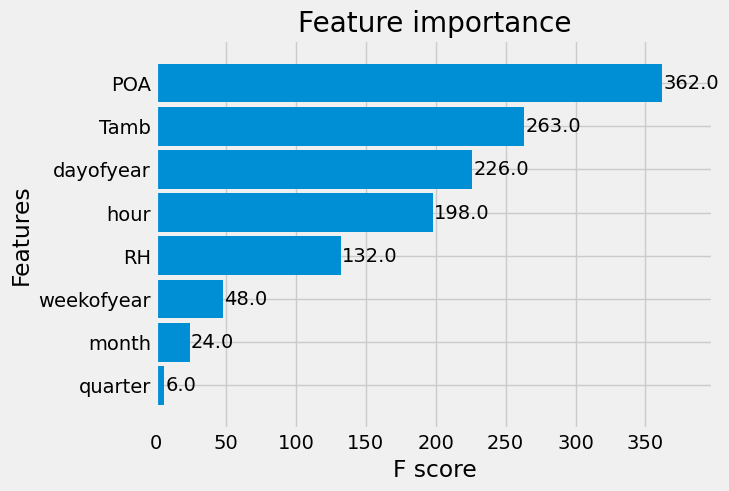

In [10]:
_ = plot_importance(reg, height=0.9)

In [11]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = (pd.concat([pjme_test, pjme_train], sort=False)
            .sort_index()
        )

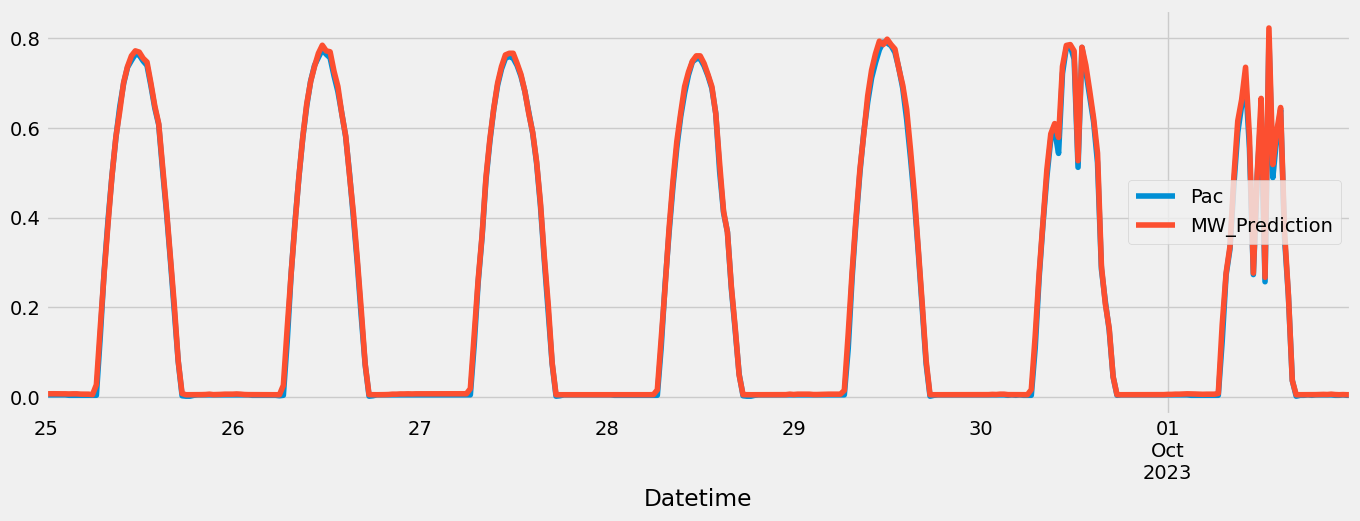

In [12]:
# Filter the dataframe for the desired date range
filtered_data = pjme_all.loc['2023-09-25':'2023-10-01']

# Plot the desired columns
_ = filtered_data[['Pac', 'MW_Prediction']].plot(figsize=(15, 5))


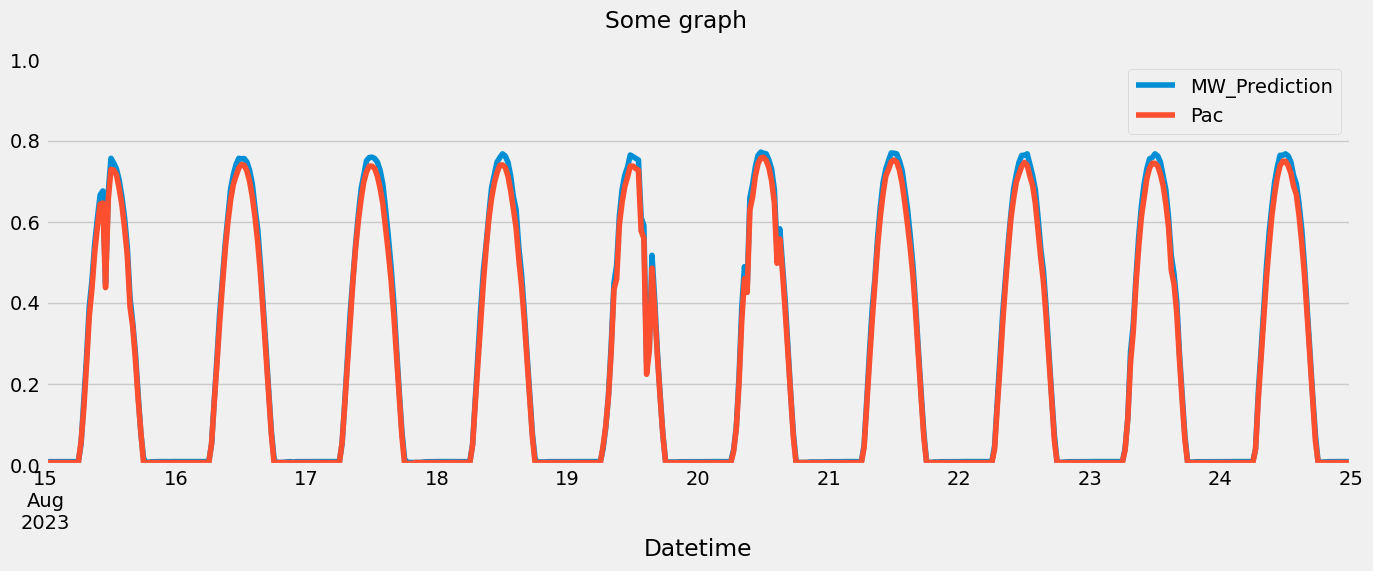

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','Pac']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='08-15-2023', upper='08-25-2023')
ax.set_ylim(0, 1)
plot = plt.suptitle('Some graph')

In [14]:
mean_squared_error(y_true=pjme_test['Pac'],
                   y_pred=pjme_test['MW_Prediction'])

0.00010075584663776384

In [15]:
mean_absolute_error(y_true=pjme_test['Pac'],
                   y_pred=pjme_test['MW_Prediction'])

0.005754387077338175

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# The 0.05 parameter eliminates distortionary divide by zero values
mean_absolute_percentage_error(y_true=pjme_test.loc[pjme_test['Pac'] > 0.2, 'Pac']
,
                   y_pred=pjme_test.loc[pjme_test['Pac'] > 0.2, 'MW_Prediction'])

2.165264180291531